In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [2]:
# Constants (Lucas-Washburn model without the b factor)
sigma = 0.072  # Surface tension (N/m)
eta = 1e-3     # Dynamic viscosity (Pa.s)
# Lucas-Washburn constants (simplified)
factor_36 = (sigma / (2 * eta)) * (10 ** 5) * (10**-9) #putting R in nm directly

In [3]:
# Constants for the problem
R_values = np.array([.678, .949, 1.221, 1.763, 2.306], dtype=np.float32)
costheta_values = np.array([0.125, 0.139, 0.158, 0.172, 0.18], dtype=np.float32)

In [4]:
# Define the neural network (NN)
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),  # Input for (R, cos(theta), t)
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)  # Output: h (interface height)
])

NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [6]:
# Loss function: Physics loss (Lucas-Washburn) and Initial Condition (IC) loss
def lucas_system(R, costheta, t, NN):
    inputs = np.hstack((R.reshape(-1, 1), costheta.reshape(-1, 1), t.reshape(-1, 1)))
    inputs = tf.constant(inputs, dtype=tf.float32)

    t_0 = tf.zeros((1, 1), dtype=tf.float32)
    R_0 = tf.constant([[0.678]], dtype=tf.float32)  # Adjusted to match the scale
    costheta_0 = tf.constant([[0.125]], dtype=tf.float32)
    h_0 = tf.zeros((1, 1), dtype=tf.float32)

    # Predicted height h from NN
    h_pred = NN(inputs)

    # Simplified Lucas-Washburn physics loss
    term1 = factor_36 * costheta * R * t
    physics_loss = h_pred - tf.sqrt(term1)

    # Initial condition loss (at t = 0, h should be 0)
    IC_inputs = tf.concat([R_0, costheta_0, t_0], axis=1)
    IC_loss = NN(IC_inputs) - h_0

    # Combined loss
    loss_sq = tf.square(physics_loss) + tf.square(IC_loss)
    return loss_sq

In [7]:
# Experimental loss function (to include known data points)
# Training data: experimental values for h (just an example)
experimental_data = np.array([
    # 5 data-points for (10,10)
    [.678, 0.125, 1, 0.25],
    [.678, 0.125, 2, 0.3125],
    [.678, 0.125, 5, 0.75],
    [.678, 0.125, 8.25, 1.25],
    [.678, 0.125, 10.75, 1.5],
    # 5 data-points for (14,14)
    [.949, 0.139, .5, 0.0625],
    [.949, 0.139, 1.5, 0.25],
    [.949, 0.139, 3, 0.5],
    [.949, 0.139, 4, 0.625],
    [.949, 0.139, 5, 0.75],
    # 5 data-points for (18,18)
    [1.221, 0.158, 1.5, 0.25],
    [1.221, 0.158, 3, 0.5],
    [1.221, 0.158, 4, 0.625],
    [1.221, 0.158, 5, 0.75],
    [1.221, 0.158, 6, 0.875],
    # 5 data-points for (26,26)
    [1.763, 0.172, .5, 0.1],
    [1.763, 0.172, 2.5, 0.4],
    [1.763, 0.172, 4, 0.6],
    [1.763, 0.172, 4.5, 0.7],
    [1.763, 0.172, 5.5, 0.8],
    # 5 data-points for (34,34)
    [2.306, 0.18, .25, 0.05],
    [2.306, 0.18, 1.25, 0.2],
    [2.306, 0.18, 2, 0.3],
    [2.306, 0.18, 2.5, 0.4],
    [2.306, 0.18, 3, 0.45]
], dtype=np.float32)

def exp_loss(NN, experimental_data):
    loss = 0.0
    for R, costheta, t, h in experimental_data:
        # Inputs include (R, cos(theta), t)
        inputs = np.array([[R, costheta, t]], dtype=np.float32)
        inputs = tf.constant(inputs, dtype=tf.float32)

        # Predicted height h from NN
        h_pred = NN(inputs)

        # Compute loss for this data point
        loss += tf.square(h_pred - h)

    return loss

In [8]:
# combined loss function
def monotonic_loss(R, costheta, t, NN, experimental_data, exp_weight):
    # Physics + IC loss
    physics_loss = lucas_system(R, costheta, t, NN)

    # Experimental loss (assign higher weight to this loss)
    exp_loss_value = exp_loss(NN, experimental_data)
    weighted_exp_loss = exp_weight * exp_loss_value  # Apply the weight to the experimental loss

    # Monotonicity penalty: check that h(t+1) > h(t)
    monotonic_penalty = 0.0
    for i in range(len(t) - 1):
        h_t = NN(tf.constant([[R[i], costheta[i], t[i]]], dtype=tf.float32))
        h_t1 = NN(tf.constant([[R[i+1], costheta[i+1], t[i+1]]], dtype=tf.float32))
        monotonic_penalty += tf.maximum(0.0, h_t - h_t1)  # Penalty when h decreases

    # Total loss (physics loss + weighted experimental loss + monotonic penalty)
    total_loss = tf.reduce_mean(physics_loss + weighted_exp_loss) + monotonic_penalty
    return total_loss

In [9]:
# Training setup
train_t = np.linspace(0.5, 12.0, 24).reshape(-1, 1)  # Time steps
train_R = np.array([0.678] * len(train_t)).reshape(-1, 1)  #  radius, constant for training
train_costheta = np.array([0.125] * len(train_t)).reshape(-1, 1)  # cos(theta), constant for training

# Convert data to float32
train_t = train_t.astype(np.float32)
train_R = train_R.astype(np.float32)
train_costheta = train_costheta.astype(np.float32)

# Training loop
train_loss_record = []
for itr in range(1000):
    with tf.GradientTape() as tape:
        train_loss = monotonic_loss(train_R, train_costheta, train_t, NN, experimental_data, 10)
        train_loss_record.append(train_loss.numpy())

        # Compute gradients and apply them
        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    # Print training progress
    if itr % 100 == 0:
        print(f"Iteration {itr}, Loss: {train_loss.numpy()}")

# torch.save(model.state_dict(), path_to_save_to)
# model = NN

# model.load_state_dict(torch.load(path_saved_to))

Iteration 0, Loss: [[68.35894]]
Iteration 100, Loss: [[1.082204]]
Iteration 200, Loss: [[1.064946]]
Iteration 300, Loss: [[1.0447911]]
Iteration 400, Loss: [[1.0348029]]
Iteration 500, Loss: [[1.0136366]]
Iteration 600, Loss: [[1.0008544]]
Iteration 700, Loss: [[0.9889322]]
Iteration 800, Loss: [[0.9812911]]
Iteration 900, Loss: [[0.9764065]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


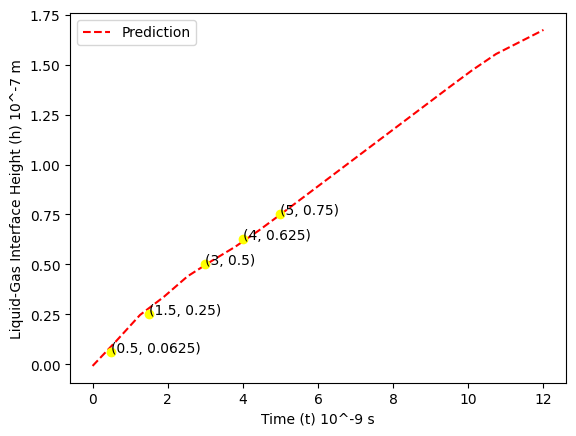

In [14]:
# Prediction
# R_0 = 0.678  # Constant R value for testing
# costheta_0 = 0.125  # Constant cos(theta) value for testing
R_0 = 0.949
costheta_0 = 0.139
# Generate test data for varying time (t)
test_t = np.linspace(0, 12, 20).reshape(-1, 1).astype(np.float32)

# Prepare input data with constant R and cos(theta), and varying t
test_inputs = np.hstack([R_0 * np.ones_like(test_t), costheta_0 * np.ones_like(test_t), test_t])
test_inputs = test_inputs.astype(np.float32)

# Predict heights for the test inputs
pred_h = NN.predict(test_inputs)

# Plot results
plt.plot(test_t, pred_h, '--r', label='Prediction')

# data_points = [
#     (1, .25),
#     (2, .3125),
#     (5, .75),
#     (8.25, 1.25),
#     (10.75, 1.5)
# ]

    # [.949, 0.139, .5, 0.0625],
    # [.949, 0.139, 1.5, 0.25],
    # [.949, 0.139, 3, 0.5],
    # [.949, 0.139, 4, 0.625],
    # [.949, 0.139, 5, 0.75],

data_points = [
    (.5, 0.0625),
    (1.5, 0.25),
    (3, 0.5),
    (4, 0.625),
    (5, 0.75)
]

plt.legend()
for t, h in data_points:
    plt.plot(t, h, 'o', color='yellow')
    plt.annotate(f'({t}, {h})', (t, h))

plt.xlabel('Time (t) 10^-9 s')
plt.ylabel('Liquid-Gas Interface Height (h) 10^-7 m')
plt.legend()
plt.show()





4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


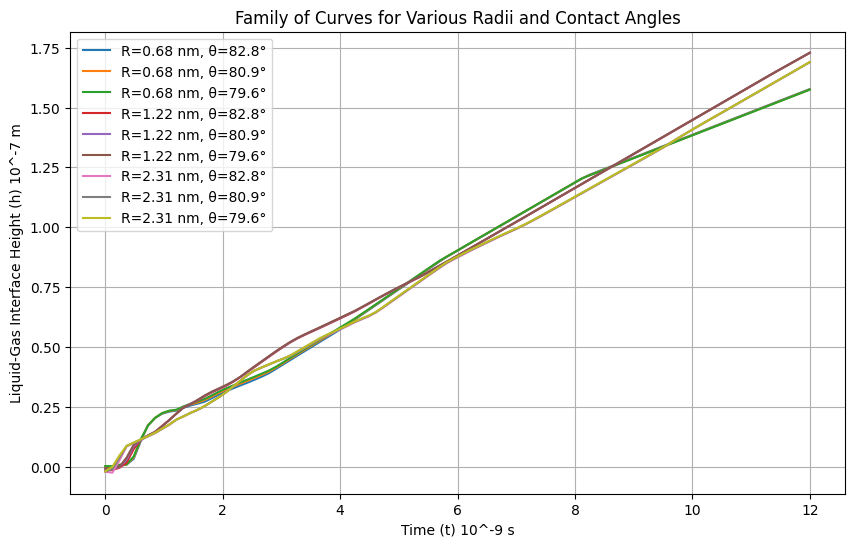

In [11]:
# Define extreme values of radii and contact angles
radii_values = [0.678, 1.221, 2.306]  # Example values: nanometers
contact_angles = [np.arccos(0.125), np.arccos(0.158), np.arccos(0.18)]  # Example angles in radians

# Define time range for prediction (same across all radii and contact angles)
test_t = np.linspace(0, 12, 100).reshape(-1, 1).astype(np.float32)  # Time range

# Generate and plot the family of curves
plt.figure(figsize=(10, 6))

for R in radii_values:
    for theta in contact_angles:
        # Create the input data for the NN: constant R and costheta, varying t
        test_inputs = np.hstack([R * np.ones_like(test_t), np.cos(theta)* np.ones_like(test_t), test_t])
        test_inputs = test_inputs.astype(np.float32)

        # Predict heights (h) using the neural network
        pred_h = NN.predict(test_inputs).ravel()

        # Plot the curve for this combination of R and costheta
        plt.plot(test_t, pred_h, label=f'R={R:.2f} nm, θ={np.degrees(theta):.1f}°')

# Customize plot
plt.xlabel('Time (t) 10^-9 s')
plt.ylabel('Liquid-Gas Interface Height (h) 10^-7 m')
plt.title('Family of Curves for Various Radii and Contact Angles')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


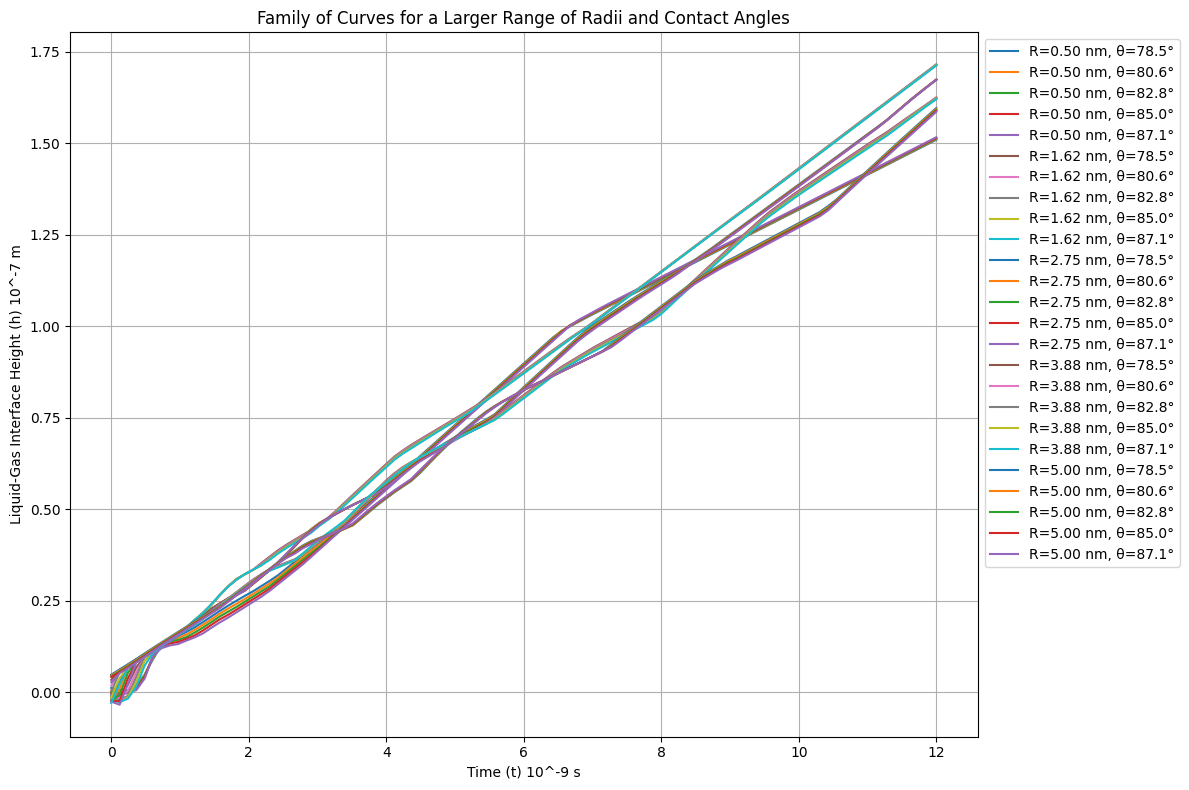

In [15]:
# Define a larger range of values for radii (R) and contact angles (theta)
radii_values = np.linspace(0.5, 5.0, 5)  # Radii values from 0.5 nm to 5.0 nm
contact_angles = np.linspace(np.arccos(0.2), np.arccos(0.05), 5)  # Example angles in radians (θ from ~78° to ~89°)

# Define time range for prediction (same across all radii and contact angles)
test_t = np.linspace(0, 12, 100).reshape(-1, 1).astype(np.float32)  # Time range

# Generate and plot the family of curves
plt.figure(figsize=(12, 8))

for R in radii_values:
    for theta in contact_angles:
        # Create the input data for the NN: constant R and costheta, varying t
        test_inputs = np.hstack([R * np.ones_like(test_t), np.cos(theta) * np.ones_like(test_t), test_t])
        test_inputs = test_inputs.astype(np.float32)

        # Predict heights (h) using the neural network
        pred_h = NN.predict(test_inputs).ravel()

        # Plot the curve for this combination of R and costheta
        plt.plot(test_t, pred_h, label=f'R={R:.2f} nm, θ={np.degrees(theta):.1f}°')

# Customize the plot
plt.xlabel('Time (t) 10^-9 s')
plt.ylabel('Liquid-Gas Interface Height (h) 10^-7 m')
plt.title('Family of Curves for a Larger Range of Radii and Contact Angles')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.grid(True)
plt.tight_layout()
plt.show()
